# Import modules

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import subprocess
import time
import multiprocessing as mp
import matplotlib.pyplot as plt
import os
from collections import Counter
import seaborn as sns
import io
import requests
from sklearn.ensemble import RandomForestClassifier
import joblib

# Initialize file paths

In [2]:
data_path = os.path.join(os.path.dirname(os.getcwd()),'data')
model_path = os.path.join(os.path.dirname(os.getcwd()),'model')
node_info_file = os.path.join(data_path, 'node_info_df.tsv')
workshop_psev_file = os.path.join(data_path, 'workshop_psevs.npy')
int_cohort_filename = os.path.join(data_path, 'example_cohort.tsv')
new_patient_info_filename = os.path.join(data_path, 'random_patient_info.tsv')
new_patient_spokesig_filename = os.path.join(data_path, 'random_patient_spokesigs.npy')
mean_node_val_filename = os.path.join(data_path, 'mean_node_val_df.tsv')
random_forest_model = os.path.join(model_path, 'random_forest_bc_cc_ibd.joblib')

# Load SPOKE file

In [3]:
print('loading SPOKE nodes ...')
node_info_df = pd.read_csv(node_info_file, sep='\t', header=0, index_col=False)

# Diseases for workshop
diseases = ['DOID:9778', 'DOID:1612', 'DOID:219']
disease_names = ['_'.join(node_info_df[node_info_df.Node==disease].Node_Name.values[0].split()) for disease in diseases]

print('loading Disease PSEVs for workshop ...')
psev_matrix = np.load(workshop_psev_file, allow_pickle=False)

loading SPOKE nodes ...
loading Disease PSEVs for workshop ...


# Load initial cohort

In [4]:
example_cohort = pd.read_csv(int_cohort_filename, sep='\t', header=0, index_col=False)
example_cohort.head()

,patient_id,Ethnicity,Sex,Smoking Status,patient_status,Race,Age,Patient_Index,train_or_test,SEP_Count,OMOP_Count,SPOKE_ID,label,Disease
0,D00040B4CC68B5,Not Hispanic or Latino,Male,Never Smoker,Alive,White or Caucasian,60,0,Train,184,152,DOID:9778,0,irritable_bowel_syndrome
1,D004224317CECE,Not Hispanic or Latino,Male,Never Smoker,Alive,White or Caucasian,70,1,Train,57,82,DOID:219,2,colon_cancer
2,D012F6D43E93F8,Not Hispanic or Latino,Male,Former Smoker,Deceased,Black or African American,68,2,Train,156,192,DOID:219,2,colon_cancer
3,D01CDFCAE04C90,Not Hispanic or Latino,Female,Current Every Day Smoker,Alive,Mixed Race/Other,53,3,Train,90,72,DOID:219,2,colon_cancer
4,D02D66C4CFF736,Not Hispanic or Latino,Male,NaN,Deceased,Mixed Race/Other,56,4,Train,56,45,DOID:219,2,colon_cancer


# Look at cohort demographics

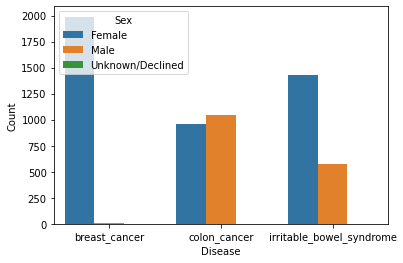

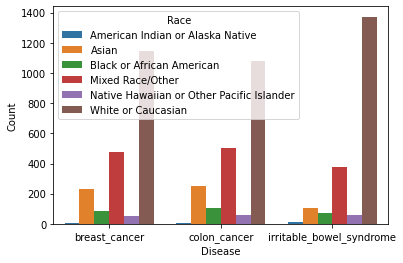

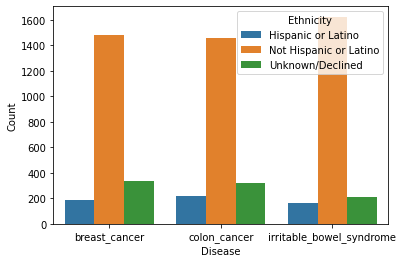

In [5]:
for col in ['Sex','Race','Ethnicity']:
    df = example_cohort[['Disease', col, 'patient_id']].groupby(['Disease', col]).count().reset_index().rename(index=str, columns={'patient_id':'Count'})
    ax=sns.barplot(x='Disease', y='Count', hue=col, data=df)
    plt.show()

# Look at cohort continuous variables

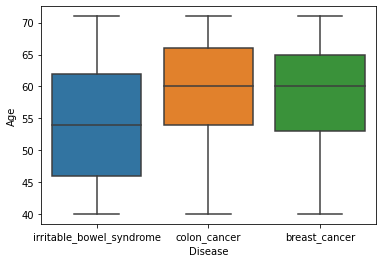

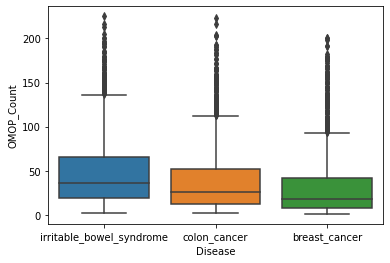

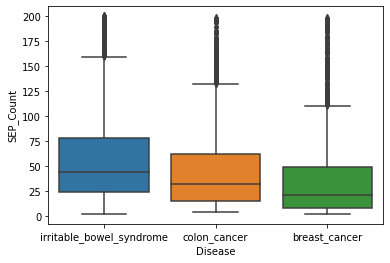

In [6]:
for col in ['Age', 'OMOP_Count', 'SEP_Count']:
    ax=sns.boxplot(x='Disease', y=col, data=example_cohort)
    plt.show()

# Load initial cohort SPOKEsigs data

In [7]:
from mapping_functions import load_or_make_spokesig_mean_std_dist
mean_sig, std_sig, patient_to_disease_dist = load_or_make_spokesig_mean_std_dist(node_info_df, example_cohort, diseases, disease_names, data_path, load_data=True)


# Compare patients to disease PSEVs

In [8]:
# find closest disease to patient
best_match = np.array(np.array(disease_names)[np.argmin(patient_to_disease_dist, axis=1)])
print(np.sum(example_cohort.Disease.values==best_match))
#
# check if closest disease is correct
example_cohort.loc[:,'pred'] = best_match
example_cohort.loc[:,'match_correct'] = example_cohort.Disease.values == example_cohort.pred.values
match_stats_df = example_cohort[['Patient_Index', 'Disease', 'pred']].groupby(['Disease','pred']).count().reset_index()
match_stats_df

4445


,Disease,pred,Patient_Index
0,breast_cancer,breast_cancer,1076
1,breast_cancer,colon_cancer,149
2,breast_cancer,irritable_bowel_syndrome,775
3,colon_cancer,breast_cancer,34
4,colon_cancer,colon_cancer,1503
5,colon_cancer,irritable_bowel_syndrome,463
6,irritable_bowel_syndrome,breast_cancer,38
7,irritable_bowel_syndrome,colon_cancer,96
8,irritable_bowel_syndrome,irritable_bowel_syndrome,1866


# Visualize cohort in 3d 
(based on distance to diseases)

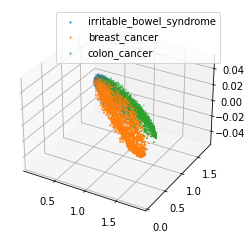

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for disease, name in zip(diseases, disease_names):
    pats = example_cohort[example_cohort.Disease==name].Patient_Index.values
    plt.scatter(patient_to_disease_dist[:,0][pats], patient_to_disease_dist[:,1][pats], patient_to_disease_dist[:,2][pats], label=name)
plt.legend()
plt.show()

# Load new patients from API

In [10]:
try:    
    new_cohort = pd.read_csv(new_patient_info_filename, sep='\t', header=0, index_col=False)
    print('new patient data is loaded')
    new_spoke_sigs = np.load(new_patient_spokesig_filename, allow_pickle=False)
    print('normalizing new patients ...')
    new_spoke_sigs = (new_spoke_sigs-mean_sig)/std_sig
except FileNotFoundError:
    print('SPOKE sigs of new patients have not been yet created using API. Run that first using "get_patient_spoke_sig_using_API.ipynb", before proceeding further.')

new patient data is loaded
normalizing new patients ...


# Compare new patients to disease PSEVs

In [11]:
new_patient_to_disease_dist = cdist(new_spoke_sigs, psev_matrix, metric='cosine')
#
best_match = np.array(np.array(disease_names)[np.argmin(new_patient_to_disease_dist, axis=1)])
print(np.sum(new_cohort.Disease.values==best_match)/len(new_cohort))
#
new_cohort.loc[:,'pred'] = best_match
new_cohort.loc[:,'match_correct'] = new_cohort.Disease.values == new_cohort.pred.values
match_stats_df = new_cohort[['Patient_Index', 'Disease', 'pred']].groupby(['Disease','pred']).count().reset_index()
match_stats_df

0.8


,Disease,pred,Patient_Index
0,breast_cancer,breast_cancer,2
1,breast_cancer,colon_cancer,1
2,breast_cancer,irritable_bowel_syndrome,2
3,colon_cancer,colon_cancer,5
4,irritable_bowel_syndrome,irritable_bowel_syndrome,5


# Load pre-trained random forest classifier (using initial cohort)

In [12]:
clf = joblib.load(random_forest_model)

/Users/student/py3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/student/py3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Test Random Forest Classifier using new patients

In [13]:
pred = clf.predict(new_spoke_sigs)
print(np.sum(new_cohort.sort_values('Patient_Index').label.values==pred)/len(new_cohort)) #0.9333333333333333

1.0


# Create node importance table

In [14]:
classifier_results = pd.read_csv(mean_node_val_filename, sep='\t', header=0, index_col=False)
classifier_results.loc[:,'feature_importance'] = clf.feature_importances_


# Set a threshold for node importance

In [15]:
# select % threshold
thresh_percentile = 99
feature_thresh = np.percentile(classifier_results.feature_importance.values, thresh_percentile)
# select number of rows to show
top_n=50

# Look at key nodes for IBS

These are the top IBS nodes that pass feature importance and IBS avg sig thresholds. Nodes are sorted by their feature importance for the RF classifier

In [16]:
col = 'irritable bowel syndrome'
thresh = np.percentile(classifier_results[col].values, thresh_percentile)
classifier_results[(classifier_results.Node_Type!='Compound')&(classifier_results.feature_importance>feature_thresh)&(classifier_results[col]>thresh)].sort_values('feature_importance', ascending=False).head(top_n)

,Node,Node_Name,Node_Type,irritable bowel syndrome,breast cancer,colon cancer,feature_importance
16059,7932,OR2H2,Gene,0.797651,-0.419548,-0.368370,0.000713
10402,503841,DEFB106B,Gene,0.790296,-0.453384,-0.317122,0.000500
18280,89872,AQP10,Gene,0.914796,-0.483133,-0.407005,0.000283
5689,245909,DEFB106A,Gene,0.789089,-0.452372,-0.316797,0.000191
29951,C0022104,Irritable bowel syndrome,SideEffect,0.773885,-0.369959,-0.398255,0.000147
22094,A0A087WV04,A0A087WV04_HUMAN,Protein,0.789840,-0.340450,-0.428641,0.000130
32229,C0701821,Onychia,SideEffect,0.846442,-0.320171,-0.544858,0.000116
343501,GO:0050955,thermoception,BiologicalProcess,0.871807,-0.502957,-0.352530,0.000111
21178,A0A024R929,A0A024R929_HUMAN,Protein,0.789840,-0.340450,-0.428641,0.000090
330562,DOID:9778,irritable bowel syndrome,Disease,0.774883,-0.388496,-0.381094,0.000066


# Look at key nodes for breast cancer

These are the top breast cancer nodes that pass feature importance and breast cancer avg sig thresholds. Nodes are sorted by their feature importance for the RF classifier

In [17]:
col = 'breast cancer'
thresh = np.percentile(classifier_results[col].values, thresh_percentile)
classifier_results[(classifier_results.Node_Type!='Compound')&(classifier_results.feature_importance>feature_thresh)&(classifier_results[col]>thresh)].sort_values('feature_importance', ascending=False).head(top_n)

,Node,Node_Name,Node_Type,irritable bowel syndrome,breast cancer,colon cancer,feature_importance
322348,DOID:0060080,Her2-receptor negative breast cancer,Disease,-0.431456,0.854654,-0.381105,0.009150
321954,DOID:0050671,female breast cancer,Disease,-0.401938,0.914889,-0.473576,0.008927
354016,P01344,IGF2_HUMAN,Protein,-0.425994,0.857144,-0.392082,0.007983
329384,DOID:6629,nipple carcinoma,Disease,-0.420256,0.851132,-0.389296,0.005016
327444,DOID:3011,breast granular cell tumor,Disease,-0.414137,0.856555,-0.399830,0.004671
33270,C9JF40,C9JF40_HUMAN,Protein,-0.434246,0.847671,-0.371900,0.004407
2487,128822,CST9,Gene,-0.444755,0.839804,-0.351386,0.004251
14369,645922,S100A7L2,Gene,-0.439869,0.910666,-0.426830,0.004183
21452,A0A024RAS2,A0A024RAS2_HUMAN,Protein,-0.420152,0.871017,-0.408082,0.003976
21657,A0A024RBZ4,A0A024RBZ4_HUMAN,Protein,-0.419963,0.847293,-0.381805,0.003856


# Look at key nodes for colon cancer

These are the top colon cancer nodes that pass feature importance and colon cancer avg sig thresholds. Nodes are sorted by their feature importance for the RF classifier

In [18]:
col = 'colon cancer'
thresh = np.percentile(classifier_results[col].values, thresh_percentile)
classifier_results[(classifier_results.Node_Type!='Compound')&(classifier_results.feature_importance>feature_thresh)&(classifier_results[col]>thresh)].sort_values('feature_importance', ascending=False).head(top_n)

,Node,Node_Name,Node_Type,irritable bowel syndrome,breast cancer,colon cancer,feature_importance
18739,9230,RAB11B,Gene,-0.477789,-0.455409,0.947020,0.004414
383324,UBERON:0015481,left hepatic artery,Anatomy,-0.398838,-0.550391,0.963545,0.004060
379096,UBERON:0005628,ileal artery,Anatomy,-0.298058,-0.613265,0.915343,0.003923
366253,Q8IY26,PLPP6_HUMAN,Protein,-0.526160,-0.401499,0.932175,0.003789
351164,N0000007151,Folic Acid,PharmacologicClass,-0.395157,-0.611473,1.000962,0.003732
8374,349334,FOXD4L4,Gene,-0.488236,-0.472483,0.967307,0.001052
327338,DOID:2781,rectosigmoid cancer,Disease,-0.467166,-0.467937,0.936980,0.000832
21803,A0A024RD58,A0A024RD58_HUMAN,Protein,-0.470513,-0.448664,0.919794,0.000651
369857,Q96P81,Q96P81_HUMAN,Protein,-0.454632,-0.475122,0.926690,0.000549
32482,C0857117,Hand rash,SideEffect,-0.462343,-0.453230,0.913236,0.000481
